In [1]:
try:
    import torch, platform
    print('Torch version:', torch.__version__)
    # Prefer CUDA if available, else MPS on Apple Silicon, else CPU
    if torch.cuda.is_available():
        print('CUDA available:', True)
        print('CUDA device count:', torch.cuda.device_count())
        try:
            print('CUDA device:', torch.cuda.get_device_name(0))
        except Exception:
            pass
        device = 'cuda'
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        print('MPS available:', True)
        print('Device:', 'Apple Silicon (MPS)' if platform.system() == 'Darwin' else 'MPS')
        device = 'mps'
    else:
        print('CUDA available:', False)
        print('MPS available:', False)
        device = 'cpu'
    print('Selected device:', device)
except Exception as e:
    print('Torch check failed:', e)

Torch version: 2.5.1
CUDA available: True
CUDA device count: 1
CUDA device: NVIDIA RTX 4500 Ada Generation
Selected device: cuda


In [2]:
import os
%pip install -r "requirements.txt"

In [3]:
# Load data
import pandas as pd

df = pd.read_csv('final_data.csv')
display(df.head())
display(df.info())

,headline,category,headline_length
0,ಆಂತರಿಕ ಕಚ್ಚಾಟ ಮರೆಮಾಚಲು ಕಾಂಗ್ರೆಸ್ ಸುಳ್ಳು ಭರವಸೆ ...,ರಾಜಕೀಯ,69
1,ಒಳ್ಳೆಯ ಸೋದರ ಎಂದರೆ ಅರ್ಥವೇನೆಂದು ರಾಹುಲ್ ಗಾಂಧಿ ವಿವ...,ರಾಜಕೀಯ,59
2,ಕೋವಿಡ್ ಬಿಕ್ಕಟ್ಟು: ಪಾಕಿಸ್ತಾನವನ್ನು ಹಾಡಿ ಹೊಗಳಿದ ಧ...,ರಾಜಕೀಯ,67
3,"ಕರ್ನಾಟಕ ಚುನಾವಣೆ 2023: ಶೂನ್ಯ ಭ್ರಷ್ಟಾಚಾರ, ಉಚಿತ ವ...",ರಾಜಕೀಯ,80
4,ಗ್ರಾಮ ಪಂಚಾಯಿತಿ ಚುನಾವಣೆ: ಮತದಾರರ ಸೆಳೆಯಲು ಹಣದ ಹೊಳ...,ರಾಜಕೀಯ,74


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60098 entries, 0 to 60097
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   headline         60098 non-null  object
 1   category         60098 non-null  object
 2   headline_length  60098 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


None

Category Distribution:
category
ಸಾಹಿತ್ಯ         7768
ತಂತ್ರಜ್ಞಾನ      7426
ರಾಜಕೀಯ          7092
ವಿದೇಶ           7090
ಕ್ರೀಡೆ          6292
ಅಪರಾಧ ಸುದ್ದಿ    5978
ವಾಣಿಜ್ಯ         5524
ಮನರಂಜನೆ         5428
ಆರೋಗ್ಯ          4967
ಕೃಷಿ            2533
Name: count, dtype: int64


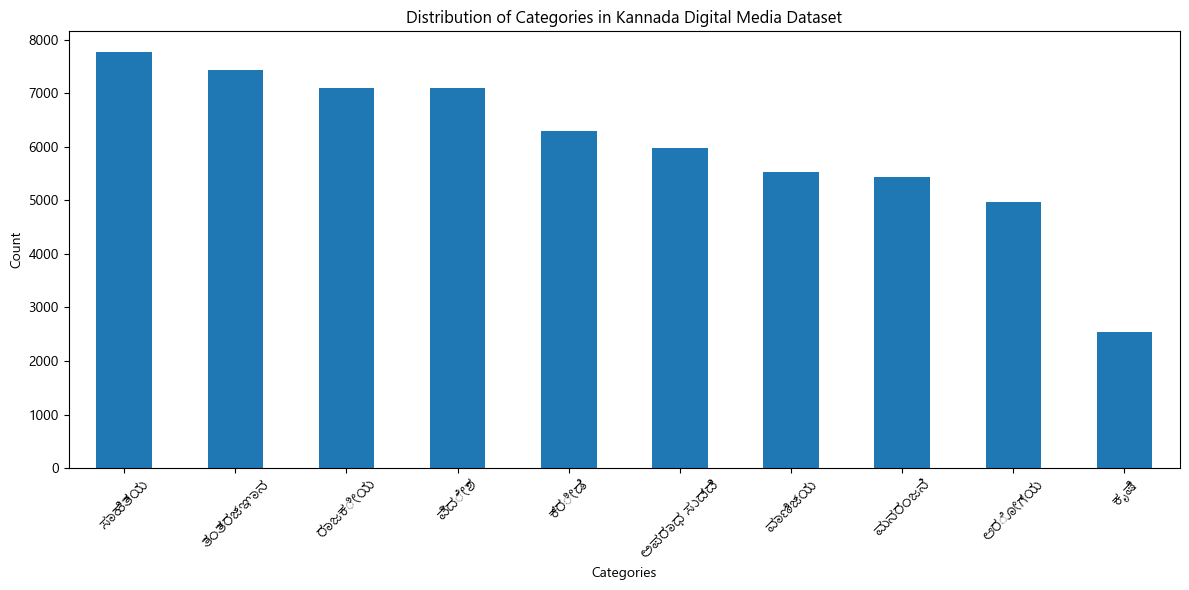


Dataset Statistics:
Total headlines: 60098
Average headline length: 75.61
Min headline length: 9
Max headline length: 921
Number of categories: 10



In [5]:
# EDA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check category distribution
category_counts = df['category'].value_counts()
print("Category Distribution:")
print(category_counts)

# Visualize category distribution
plt.figure(figsize=(12, 6))
plt.rcParams['font.family'] = ['Nirmala UI', 'sans-serif']
category_counts.plot(kind='bar', rot=45)
plt.title('Distribution of Categories in Kannada Digital Media Dataset')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Basic text statistics
print(f"\nDataset Statistics:")
print(f"Total headlines: {len(df)}")
print(f"Average headline length: {df['headline_length'].mean():.2f}")
print(f"Min headline length: {df['headline_length'].min()}")
print(f"Max headline length: {df['headline_length'].max()}")
print(f"Number of categories: {df['category'].nunique()}\n")

In [6]:
# Preprocessing: Kannada normalization, tokenization, stopword removal
import re
import pandas as pd
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from indicnlp.tokenize import indic_tokenize

# Initialize normalizer for Kannada
normalizer = IndicNormalizerFactory().get_normalizer('kn')

# Basic Kannada stopwords (extend as needed)
kannada_stopwords = set([
    'ಮತ್ತು','ಆದರೆ','ಹಾಗೂ','ಇದು','ಅದು','ಇಲ್ಲಿ','ಅಲ್ಲಿ','ಒಂದು','ಎಂದು','ಈ','ಆ','ಕೆಲವು','ಎಲ್ಲಾ','ಯಾವ','ಯಾರು','ಏಕೆ','ಏನು','ಹೆಚ್ಚು','ಕಡಿಮೆ','ನಲ್ಲಿ','ರಿಂದ','ಗೆ','ದ','ಮೇಲೆ','ಕೆಳಗೆ','ಗೂ','ವೂ','ಇನ್ನೂ','ಆಗ','ಹಾಗೆ','ಆದ','ಇದ','ಇತ್ಯಾದಿ'
])

# Basic cleaning: remove URLs, punctuation, digits; normalize whitespace
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'[\d]', ' ', text)
    text = re.sub(r'[\u0021-\u0040\u005B-\u0060\u007B-\u007E]', ' ', text)  # ASCII punct
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Full normalize + token filter
def preprocess_kn(text: str) -> str:
    text = clean_text(text)
    text = normalizer.normalize(text)
    # Tokenize using Indic tokenizer (does not require external models)
    tokens = [t for t in indic_tokenize.trivial_tokenize(text, lang='kn')]
    tokens = [t for t in tokens if t not in kannada_stopwords and len(t) > 1]
    return ' '.join(tokens)

# Apply to the dataframe
texts = df['headline'].astype(str).fillna('')
texts_clean = texts.apply(preprocess_kn)

# Drop empty after cleaning
mask_nonempty = texts_clean.str.strip().str.len() > 0
X_texts = texts_clean[mask_nonempty].reset_index(drop=True)
Y_cat = df.loc[mask_nonempty, 'category'].astype(str).reset_index(drop=True)
print('After cleaning:', len(X_texts), 'documents')

After cleaning: 60098 documents


In [7]:
# Train/Test split and embeddings
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import torch

X_train, X_test, y_train, y_test = train_test_split(
    X_texts, Y_cat, test_size=0.2, random_state=42, stratify=Y_cat
)
print('Train size:', len(X_train), 'Test size:', len(X_test))

# # Choose a multilingual model good for Indian languages
# # Options: 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' or 'Alibaba-NLP/gte-multilingual-base'
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
embedder = SentenceTransformer(model_name, device='mps' if torch.backends.mps.is_available() else 'cpu')

# # Compute embeddings (batched)
train_embeddings = embedder.encode(X_train.tolist(), batch_size=256, show_progress_bar=True, convert_to_numpy=True)
test_embeddings = embedder.encode(X_test.tolist(), batch_size=256, show_progress_bar=True, convert_to_numpy=True)


Train size: 48078 Test size: 12020
Train size: 48078 Test size: 12020


Batches:   0%|          | 0/188 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

In [8]:
# Prepare labeled data (Kannada)
import pandas as pd
from sklearn.model_selection import train_test_split

# Use already cleaned Kannada texts and labels if present
texts_supervised = X_texts if 'X_texts' in globals() else df['headline'].astype(str)
labels_supervised = Y_cat if 'Y_cat' in globals() else df['category'].astype(str)

# Keep top 10 categories by frequency if there are more, else enforce exactly 10
cat_counts = labels_supervised.value_counts()
if len(cat_counts) >= 10:
    top10 = cat_counts.index[:10]
    mask10 = labels_supervised.isin(top10)
    texts_supervised = texts_supervised[mask10].reset_index(drop=True)
    labels_supervised = labels_supervised[mask10].reset_index(drop=True)
else:
    top10 = cat_counts.index

# Stratified split 80/20, then carve out 10% of train for validation
X_tr, X_te, y_tr, y_te = train_test_split(texts_supervised, labels_supervised, test_size=0.2, random_state=42, stratify=labels_supervised)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.1, random_state=42, stratify=y_tr)

print('Train/Val/Test sizes:', len(X_tr), len(X_va), len(X_te))
print('Classes:', sorted(set(y_tr)))

Train/Val/Test sizes: 43270 4808 12020
Classes: ['ಅಪರಾಧ ಸುದ್ದಿ', 'ಆರೋಗ್ಯ', 'ಕೃಷಿ', 'ಕ್ರೀಡೆ', 'ತಂತ್ರಜ್ಞಾನ', 'ಮನರಂಜನೆ', 'ರಾಜಕೀಯ', 'ವಾಣಿಜ್ಯ', 'ವಿದೇಶ', 'ಸಾಹಿತ್ಯ']


In [26]:
# Train three deep learning models and summarize (macOS MPS-ready)

import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Encode labels
le = LabelEncoder()
y_tr_enc = le.fit_transform(y_tr)
y_va_enc = le.transform(y_va)
y_te_enc = le.transform(y_te)
num_labels = len(le.classes_)

# Prefer CUDA, else MPS (Apple Silicon), else CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device for multi-model training:', device)
# Allow CPU fallback for unsupported MPS ops
os.environ.setdefault('PYTORCH_ENABLE_MPS_FALLBACK', '1')


def train_kn_classifier(model_ckpt: str, out_dir: str, epochs: int = 1, lr: float = 2e-5,
                        train_bs: int = 32, eval_bs: int = 64, max_len: int = 128,
                        log_steps: int = 100):
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    def tok_fn(batch):
        return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=max_len)

    # Use the encoded labels defined outside the function
    train_ds = Dataset.from_dict({'text': X_tr.tolist(), 'label': y_tr_enc})
    val_ds = Dataset.from_dict({'text': X_va.tolist(), 'label': y_va_enc})
    test_ds = Dataset.from_dict({'text': X_te.tolist(), 'label': y_te_enc})

    train_ds = train_ds.map(tok_fn, batched=True)
    val_ds = val_ds.map(tok_fn, batched=True)
    test_ds = test_ds.map(tok_fn, batched=True)

    cols = ['input_ids', 'attention_mask', 'label']
    train_ds.set_format(type='torch', columns=cols)
    val_ds.set_format(type='torch', columns=cols)
    test_ds.set_format(type='torch', columns=cols)

    # Model
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

    # Move to the selected device (Trainer/Accelerate also manages placement)
    try:
        model.to('cpu')
    except Exception:
        pass

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy_score(labels, preds)
        p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
        return {'accuracy': acc, 'macro_f1': f1, 'macro_precision': p, 'macro_recall': r}

    # Mixed precision only on CUDA; disable on MPS/CPU
    use_fp16 = (device == 'cuda')

    args = TrainingArguments(
        output_dir=out_dir,
        per_device_train_batch_size=train_bs,
        per_device_eval_batch_size=eval_bs,
        learning_rate=lr,
        weight_decay=0.01,
        num_train_epochs=epochs,
        eval_steps=500,
        save_steps=1000,
        logging_steps=log_steps,
        fp16=use_fp16
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    test_metrics = trainer.evaluate(test_ds)

    # Save model, tokenizer, and labels
    os.makedirs(out_dir, exist_ok=True)
    save_dir = os.path.join(out_dir, 'best_model')
    trainer.save_model(save_dir)
    try:
        tokenizer.save_pretrained(save_dir)
    except Exception:
        pass
    with open(os.path.join(out_dir, 'label_map.txt'), 'w', encoding='utf-8') as f:
        for i, cls in enumerate(le.classes_):
            f.write(f"{i}\t{cls}\n")

    return test_metrics


Selected device for multi-model training: cuda


In [11]:
# Clean training loop for multilingual models using previously defined train_kn_classifier
# Removes earlier broken code that referenced undefined DataFrames.
import os

results = {}
models = [
    ('xlm-roberta-base', 'cls_kn_xlmr'),
    ('bert-base-multilingual-cased', 'cls_kn_mbert'),
    ('distilbert-base-multilingual-cased', 'cls_kn_distilmbert'),
]

for ckpt, out in models:
    print(f"\n=== Training / Evaluating {ckpt} -> {out} ===")
    best_model_cfg = os.path.join(out, 'best_model', 'config.json')
    try:
        metrics = train_kn_classifier(ckpt, out_dir=out, epochs=1)
        results[ckpt] = metrics
        print('Test metrics:', metrics)
    except Exception as e:
        print(f'ERROR training {ckpt}:', e)
        results[ckpt] = {'error': str(e)}

print("\nSummary (macro_f1 where available):")
for ckpt, m in results.items():
    macro_f1 = m.get('eval_macro_f1') if isinstance(m, dict) else None
    print(f"{ckpt}: {macro_f1 if macro_f1 is not None else m}")


=== Training / Evaluating xlm-roberta-base -> cls_kn_xlmr ===


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\SICRNSIT\AppData\Local\Temp\ipykernel_37976\3190011421.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\SICRNSIT\AppData\Local\Temp\ipykernel_37976\3190011421.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,1.770400
200,1.053700
300,0.895100
400,0.807700
500,0.773000
600,0.724200
700,0.693400
800,0.670000
900,0.681600
1000,0.619100


Test metrics: {'eval_loss': 0.5624299049377441, 'eval_accuracy': 0.8336106489184693, 'eval_macro_f1': 0.827751960495128, 'eval_macro_precision': 0.8295993682869218, 'eval_macro_recall': 0.8285486626963797, 'eval_runtime': 6.5558, 'eval_samples_per_second': 1833.503, 'eval_steps_per_second': 28.677, 'epoch': 1.0}

=== Training / Evaluating bert-base-multilingual-cased -> cls_kn_mbert ===


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\SICRNSIT\AppData\Local\Temp\ipykernel_37976\3190011421.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,1.913300
200,1.201100
300,1.023600
400,0.929500
500,0.880800
600,0.820700
700,0.786800
800,0.774100
900,0.744200
1000,0.712300


Test metrics: {'eval_loss': 0.6361194252967834, 'eval_accuracy': 0.803910149750416, 'eval_macro_f1': 0.7948568889202062, 'eval_macro_precision': 0.7979410954088829, 'eval_macro_recall': 0.792995207441367, 'eval_runtime': 6.5883, 'eval_samples_per_second': 1824.446, 'eval_steps_per_second': 28.535, 'epoch': 1.0}

=== Training / Evaluating distilbert-base-multilingual-cased -> cls_kn_distilmbert ===


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\SICRNSIT\AppData\Local\Temp\ipykernel_37976\3190011421.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,2.064700
200,1.609200
300,1.358700
400,1.190900
500,1.100400
600,1.036200
700,0.972600
800,0.940000
900,0.935800
1000,0.852500


Test metrics: {'eval_loss': 0.7804274559020996, 'eval_accuracy': 0.7576539101497504, 'eval_macro_f1': 0.7458357741946047, 'eval_macro_precision': 0.747202638626711, 'eval_macro_recall': 0.7458033428604189, 'eval_runtime': 3.8612, 'eval_samples_per_second': 3112.993, 'eval_steps_per_second': 48.689, 'epoch': 1.0}

Summary (macro_f1 where available):
xlm-roberta-base: 0.827751960495128
bert-base-multilingual-cased: 0.7948568889202062
distilbert-base-multilingual-cased: 0.7458357741946047



=== Training / Evaluating xlm-roberta-base -> cls_kn_xlmr ===
--- Run 1/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.807500
200,1.071100
300,0.903500
400,0.826700
500,0.783300
600,0.732500
700,0.700900
800,0.680700
900,0.692200
1000,0.632900


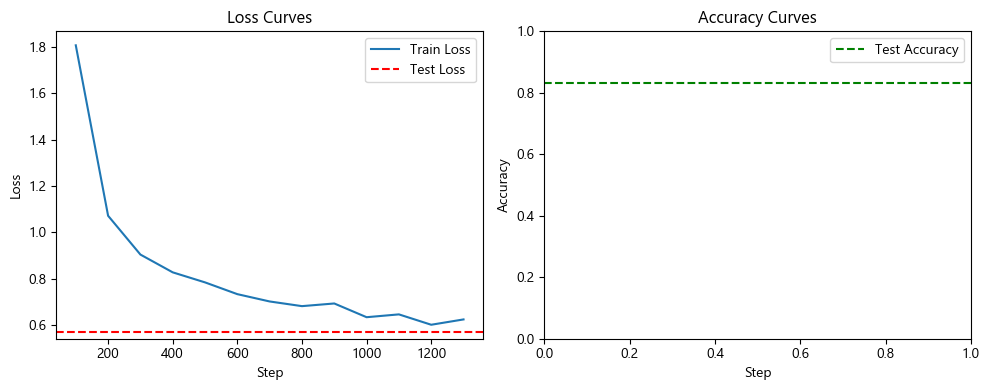

Test metrics: {'eval_loss': 0.5682945251464844, 'eval_accuracy': 0.8317803660565724, 'eval_macro_f1': 0.8252859206126371, 'eval_macro_precision': 0.8281502520181071, 'eval_macro_recall': 0.8255701054810946, 'eval_runtime': 8.4202, 'eval_samples_per_second': 1427.525, 'eval_steps_per_second': 22.327, 'epoch': 1.0}
--- Run 2/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.764500
200,1.085200
300,0.899800
400,0.832100
500,0.779300
600,0.729700
700,0.693200
800,0.666700
900,0.676800
1000,0.622200


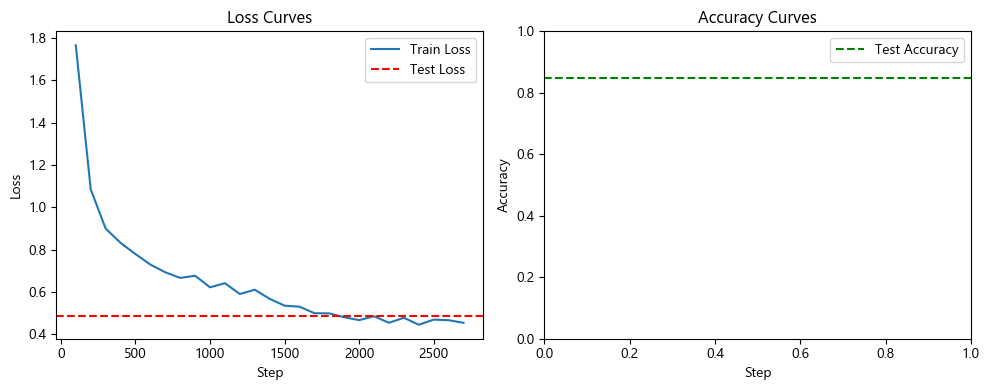

Test metrics: {'eval_loss': 0.4866845905780792, 'eval_accuracy': 0.8495840266222962, 'eval_macro_f1': 0.8440151749551725, 'eval_macro_precision': 0.8478189691080578, 'eval_macro_recall': 0.8415202973690793, 'eval_runtime': 8.1345, 'eval_samples_per_second': 1477.66, 'eval_steps_per_second': 23.111, 'epoch': 2.0}
--- Run 3/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.824800
200,1.075900
300,0.895400
400,0.817900
500,0.764700
600,0.735900
700,0.693900
800,0.680000
900,0.695400
1000,0.628300


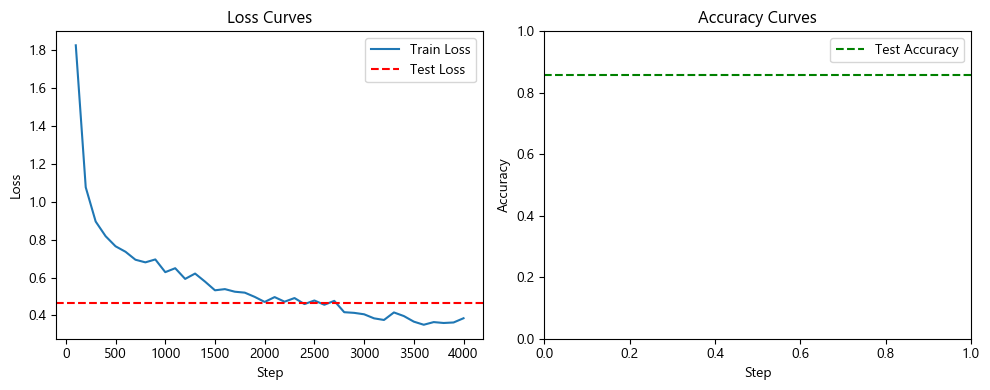

Test metrics: {'eval_loss': 0.46427762508392334, 'eval_accuracy': 0.8566555740432612, 'eval_macro_f1': 0.851565794934398, 'eval_macro_precision': 0.8542109803897123, 'eval_macro_recall': 0.8498038175890471, 'eval_runtime': 8.2084, 'eval_samples_per_second': 1464.353, 'eval_steps_per_second': 22.903, 'epoch': 3.0}
--- Run 4/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.830200
200,1.054900
300,0.919800
400,0.830000
500,0.790400
600,0.725000
700,0.699500
800,0.682000
900,0.688800
1000,0.636100


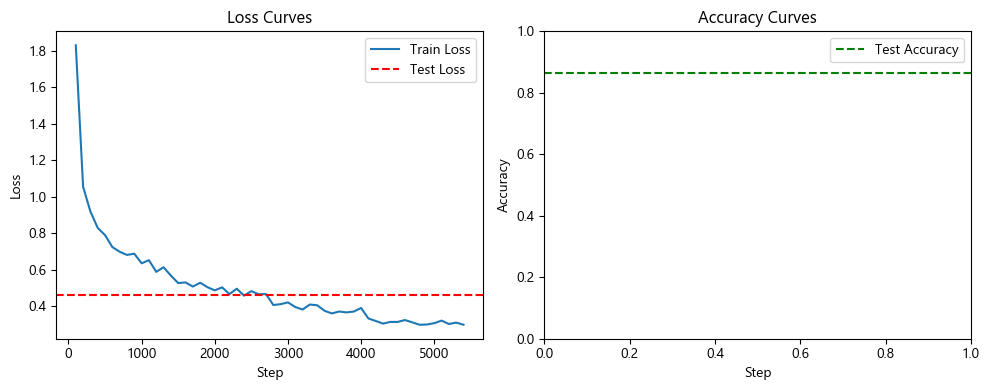

Test metrics: {'eval_loss': 0.4631102383136749, 'eval_accuracy': 0.8630615640599002, 'eval_macro_f1': 0.8590293391763231, 'eval_macro_precision': 0.8621382856770772, 'eval_macro_recall': 0.8572457534289752, 'eval_runtime': 6.7587, 'eval_samples_per_second': 1778.447, 'eval_steps_per_second': 27.816, 'epoch': 4.0}
--- Run 5/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.775700
200,1.059000
300,0.899000
400,0.804500
500,0.765000
600,0.727100
700,0.681600
800,0.673000
900,0.684200
1000,0.630500


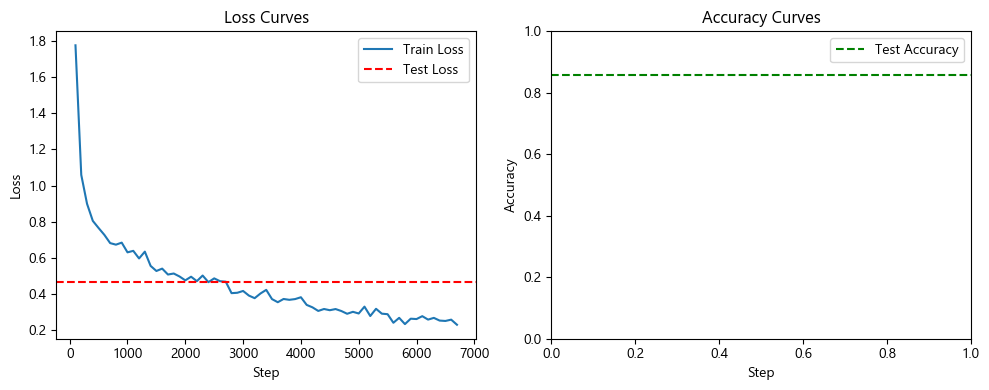

Test metrics: {'eval_loss': 0.4675963222980499, 'eval_accuracy': 0.8589850249584027, 'eval_macro_f1': 0.8549564750771026, 'eval_macro_precision': 0.8582255020469756, 'eval_macro_recall': 0.853291847399524, 'eval_runtime': 6.7985, 'eval_samples_per_second': 1768.037, 'eval_steps_per_second': 27.653, 'epoch': 5.0}

=== Training / Evaluating bert-base-multilingual-cased -> cls_kn_mbert ===
--- Run 1/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.737000
200,1.222100
300,1.024300
400,0.923400
500,0.873500
600,0.821600
700,0.778900
800,0.785500
900,0.757000
1000,0.723500


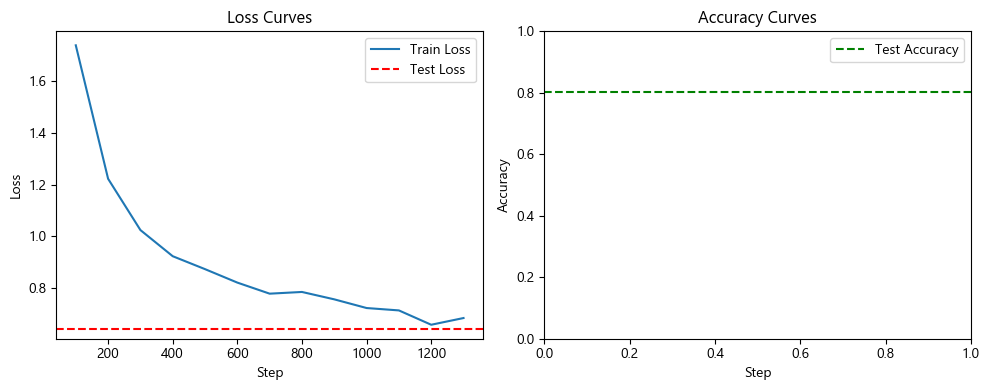

Test metrics: {'eval_loss': 0.6439199447631836, 'eval_accuracy': 0.8037437603993345, 'eval_macro_f1': 0.7950839042206541, 'eval_macro_precision': 0.7988649937514805, 'eval_macro_recall': 0.7926892726922168, 'eval_runtime': 6.7802, 'eval_samples_per_second': 1772.804, 'eval_steps_per_second': 27.728, 'epoch': 1.0}
--- Run 2/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.833500
200,1.187600
300,1.008200
400,0.905900
500,0.880400
600,0.821400
700,0.799400
800,0.774400
900,0.749000
1000,0.712500


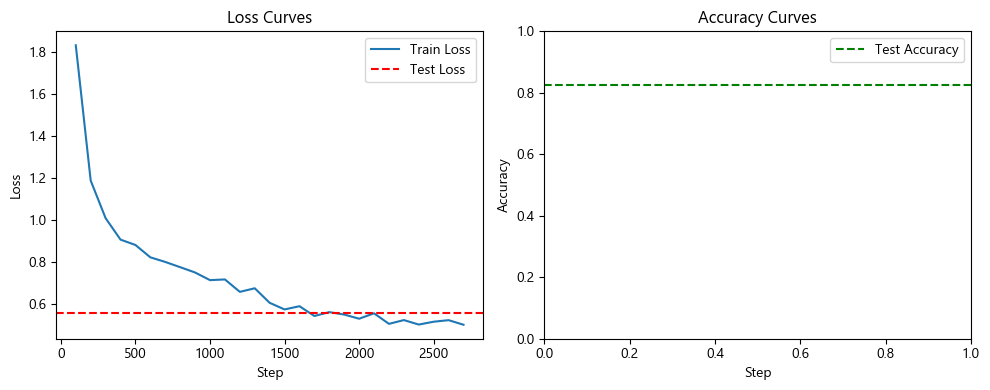

Test metrics: {'eval_loss': 0.5572170615196228, 'eval_accuracy': 0.8263727121464226, 'eval_macro_f1': 0.8191993905021621, 'eval_macro_precision': 0.8223035085939742, 'eval_macro_recall': 0.8171547395240444, 'eval_runtime': 6.8079, 'eval_samples_per_second': 1765.586, 'eval_steps_per_second': 27.615, 'epoch': 2.0}
--- Run 3/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.784400
200,1.175400
300,1.000100
400,0.898000
500,0.849200
600,0.806300
700,0.784600
800,0.775000
900,0.740900
1000,0.708300


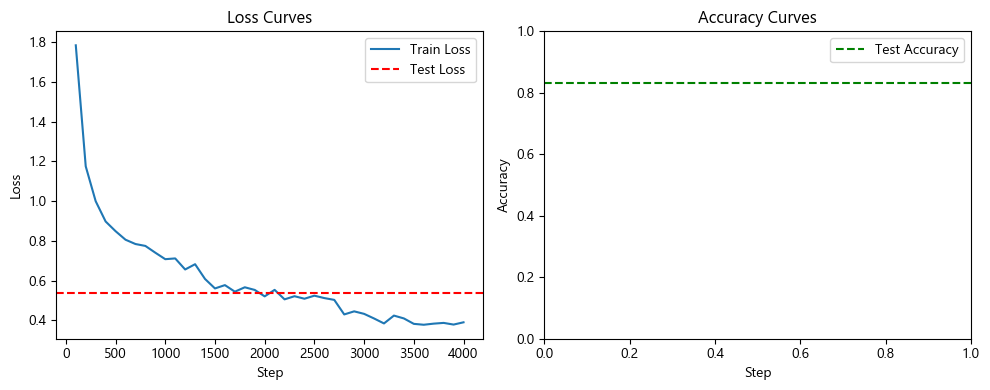

Test metrics: {'eval_loss': 0.5398162603378296, 'eval_accuracy': 0.8317803660565724, 'eval_macro_f1': 0.8249853226727923, 'eval_macro_precision': 0.8292631121196831, 'eval_macro_recall': 0.8222341129705516, 'eval_runtime': 6.9252, 'eval_samples_per_second': 1735.678, 'eval_steps_per_second': 27.147, 'epoch': 3.0}
--- Run 4/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.707200
200,1.164700
300,1.012500
400,0.903400
500,0.858900
600,0.820100
700,0.784600
800,0.765500
900,0.757000
1000,0.706500


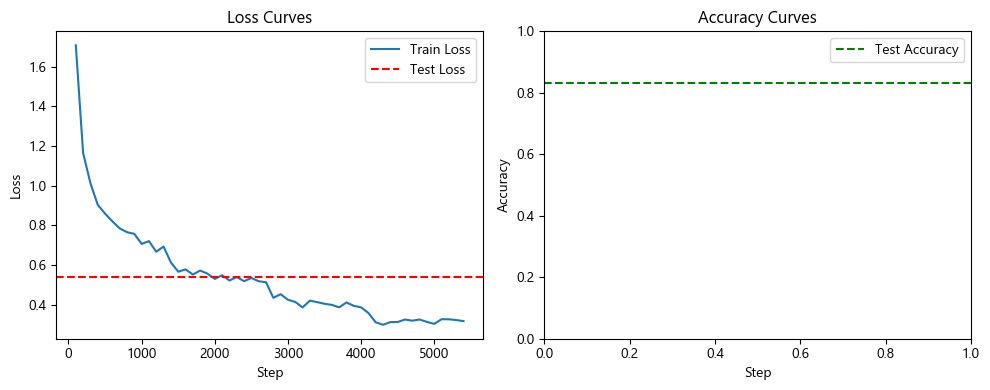

Test metrics: {'eval_loss': 0.5414204001426697, 'eval_accuracy': 0.8328618968386023, 'eval_macro_f1': 0.8263951470571318, 'eval_macro_precision': 0.8295574371530338, 'eval_macro_recall': 0.8247826193520748, 'eval_runtime': 6.7617, 'eval_samples_per_second': 1777.667, 'eval_steps_per_second': 27.804, 'epoch': 4.0}
--- Run 5/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.761600
200,1.200200
300,1.030100
400,0.919000
500,0.857800
600,0.831300
700,0.784900
800,0.795300
900,0.750100
1000,0.713100


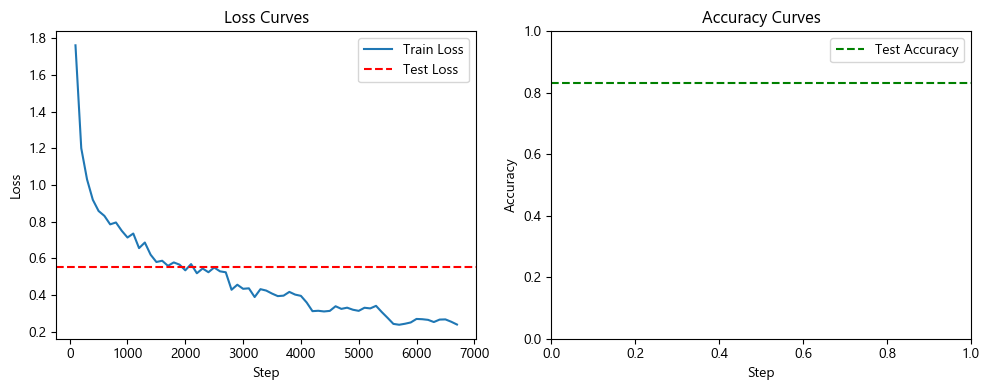

Test metrics: {'eval_loss': 0.5546382069587708, 'eval_accuracy': 0.8331946755407654, 'eval_macro_f1': 0.8264632316813231, 'eval_macro_precision': 0.8288267339714469, 'eval_macro_recall': 0.8255458432342746, 'eval_runtime': 6.7983, 'eval_samples_per_second': 1768.088, 'eval_steps_per_second': 27.654, 'epoch': 5.0}

=== Training / Evaluating distilbert-base-multilingual-cased -> cls_kn_distilmbert ===
--- Run 1/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,2.027000
200,1.632800
300,1.379500
400,1.225900
500,1.121500
600,1.059400
700,0.996700
800,0.970700
900,0.959100
1000,0.879700


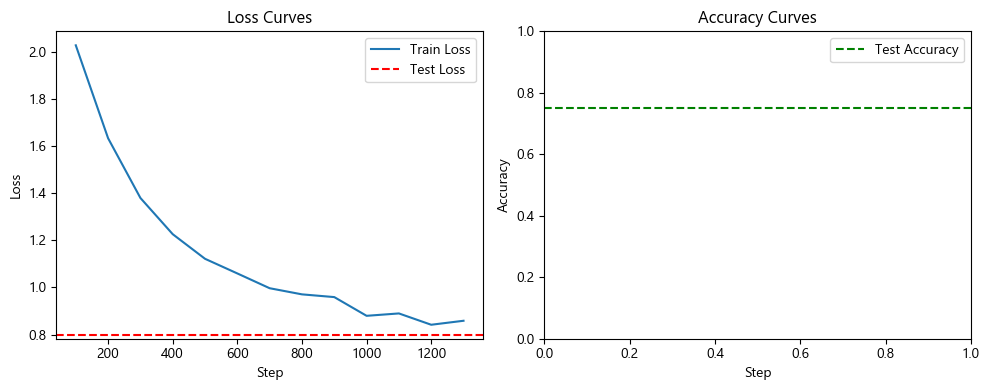

Test metrics: {'eval_loss': 0.7973676919937134, 'eval_accuracy': 0.7511647254575707, 'eval_macro_f1': 0.7390413351589925, 'eval_macro_precision': 0.7399033856297003, 'eval_macro_recall': 0.7397057921368972, 'eval_runtime': 4.1283, 'eval_samples_per_second': 2911.621, 'eval_steps_per_second': 45.539, 'epoch': 1.0}
--- Run 2/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,2.060100
200,1.599800
300,1.343800
400,1.167900
500,1.072700
600,1.007200
700,0.935200
800,0.914200
900,0.895900
1000,0.821200


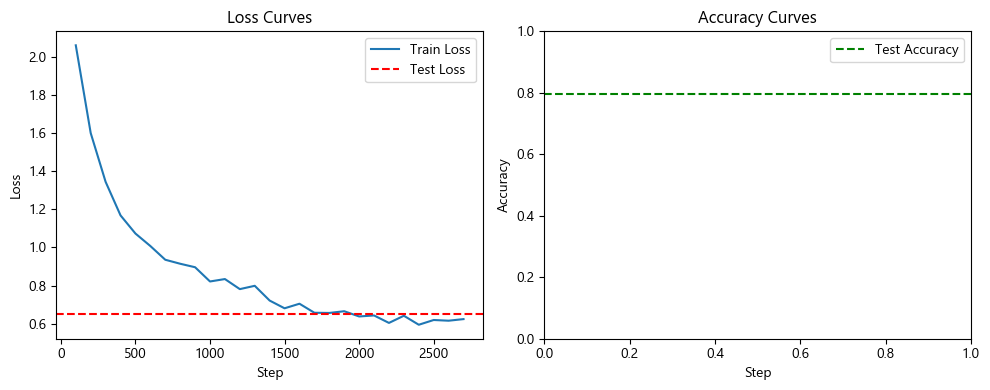

Test metrics: {'eval_loss': 0.64882892370224, 'eval_accuracy': 0.7967554076539102, 'eval_macro_f1': 0.7865898388286883, 'eval_macro_precision': 0.7883024704784213, 'eval_macro_recall': 0.7858575210896566, 'eval_runtime': 4.0248, 'eval_samples_per_second': 2986.467, 'eval_steps_per_second': 46.71, 'epoch': 2.0}
--- Run 3/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,2.026500
200,1.587400
300,1.321000
400,1.165800
500,1.071200
600,1.016100
700,0.941500
800,0.913600
900,0.890800
1000,0.843600


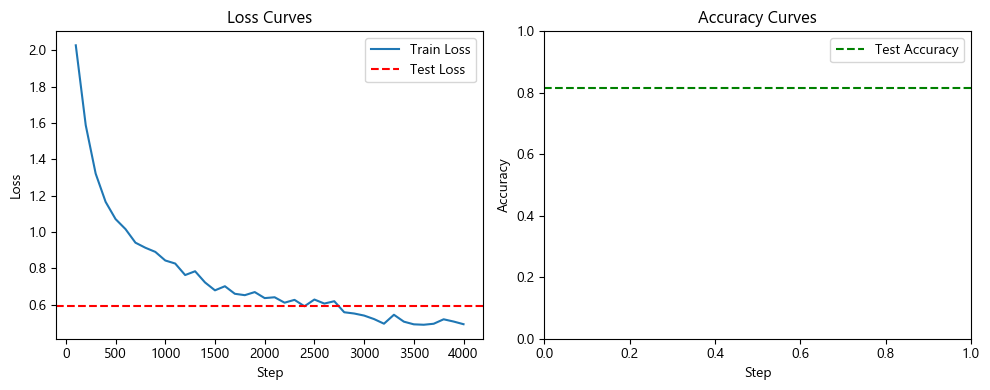

Test metrics: {'eval_loss': 0.5956283211708069, 'eval_accuracy': 0.8146422628951747, 'eval_macro_f1': 0.8063891727086411, 'eval_macro_precision': 0.8098249906307171, 'eval_macro_recall': 0.8038087642849565, 'eval_runtime': 4.1003, 'eval_samples_per_second': 2931.462, 'eval_steps_per_second': 45.85, 'epoch': 3.0}
--- Run 4/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,2.048900
200,1.550000
300,1.282800
400,1.113700
500,1.027100
600,0.981100
700,0.905200
800,0.905100
900,0.888600
1000,0.820800


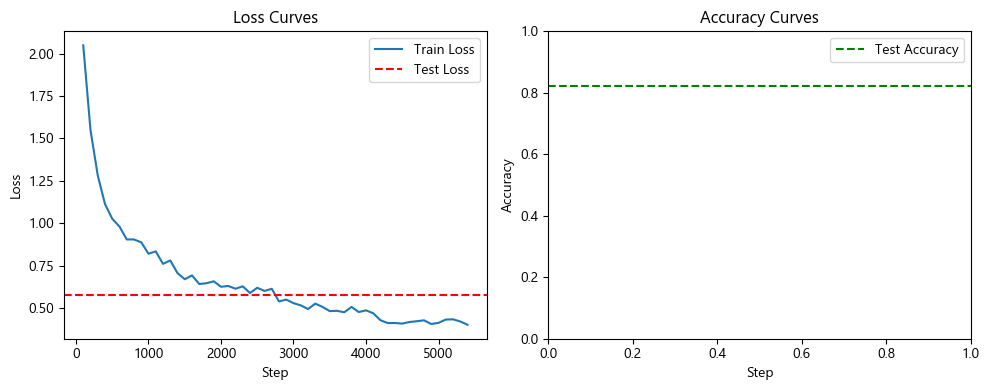

Test metrics: {'eval_loss': 0.5764469504356384, 'eval_accuracy': 0.8220465890183029, 'eval_macro_f1': 0.8152594751379368, 'eval_macro_precision': 0.8173477667296638, 'eval_macro_recall': 0.814141370091854, 'eval_runtime': 4.0579, 'eval_samples_per_second': 2962.121, 'eval_steps_per_second': 46.329, 'epoch': 4.0}
--- Run 5/5 ---


Map:   0%|          | 0/43270 [00:00<?, ? examples/s]

Map:   0%|          | 0/4808 [00:00<?, ? examples/s]

Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,2.025800
200,1.597200
300,1.377600
400,1.184900
500,1.069000
600,1.009900
700,0.938400
800,0.932600
900,0.914800
1000,0.837200


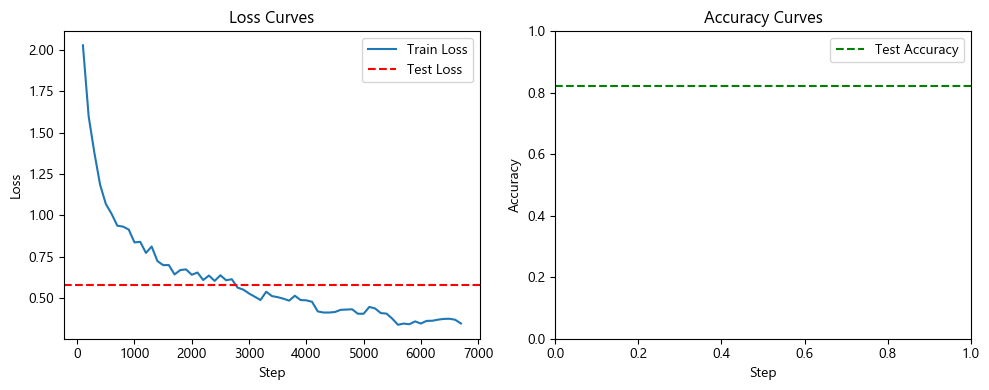

Test metrics: {'eval_loss': 0.5832282900810242, 'eval_accuracy': 0.8218801996672213, 'eval_macro_f1': 0.8153513174001692, 'eval_macro_precision': 0.8186433735830663, 'eval_macro_recall': 0.8130246714015688, 'eval_runtime': 4.0703, 'eval_samples_per_second': 2953.105, 'eval_steps_per_second': 46.188, 'epoch': 5.0}

Summary (macro_f1 where available):
xlm-roberta-base_run_1: 0.8252859206126371
xlm-roberta-base_run_2: 0.8440151749551725
xlm-roberta-base_run_3: 0.851565794934398
xlm-roberta-base_run_4: 0.8590293391763231
xlm-roberta-base_run_5: 0.8549564750771026
bert-base-multilingual-cased_run_1: 0.7950839042206541
bert-base-multilingual-cased_run_2: 0.8191993905021621
bert-base-multilingual-cased_run_3: 0.8249853226727923
bert-base-multilingual-cased_run_4: 0.8263951470571318
bert-base-multilingual-cased_run_5: 0.8264632316813231
distilbert-base-multilingual-cased_run_1: 0.7390413351589925
distilbert-base-multilingual-cased_run_2: 0.7865898388286883
distilbert-base-multilingual-cased_ru

In [27]:
# Clean training loop for multilingual models using previously defined train_kn_classifier
# Removes earlier broken code that referenced undefined DataFrames.
import os

finetune_results = {}
models = [
    ('xlm-roberta-base', 'cls_kn_xlmr'),
    ('bert-base-multilingual-cased', 'cls_kn_mbert'),
    ('distilbert-base-multilingual-cased', 'cls_kn_distilmbert'),
]

for ckpt, out in models:
    
    print(f"\n=== Training / Evaluating {ckpt} -> {out} ===")
    best_model_cfg = os.path.join(out, 'best_model', 'config.json')
    try:
        for epoch in range(1,6):
            print(f"--- Run {epoch}/5 ---")
            metrics = train_kn_classifier(ckpt, out_dir=out, epochs=epoch)
            finetune_results[f'{ckpt}_run_{epoch}'] = metrics
            print('Test metrics:', metrics)
    except Exception as e:
        print(f'ERROR training {ckpt}:', e)
        finetune_results[f'{ckpt}_run_{epoch}'] = {'error': str(e)}

print("\nSummary (macro_f1 where available):")
for ckpt, m in finetune_results.items():
    macro_f1 = m.get('eval_macro_f1') if isinstance(m, dict) else None
    print(f"{ckpt}: {macro_f1 if macro_f1 is not None else m}")

In [30]:
finetune_results

{'xlm-roberta-base_run_1': {'eval_loss': 0.5682945251464844,
  'eval_accuracy': 0.8317803660565724,
  'eval_macro_f1': 0.8252859206126371,
  'eval_macro_precision': 0.8281502520181071,
  'eval_macro_recall': 0.8255701054810946,
  'eval_runtime': 8.4202,
  'eval_samples_per_second': 1427.525,
  'eval_steps_per_second': 22.327,
  'epoch': 1.0},
 'xlm-roberta-base_run_2': {'eval_loss': 0.4866845905780792,
  'eval_accuracy': 0.8495840266222962,
  'eval_macro_f1': 0.8440151749551725,
  'eval_macro_precision': 0.8478189691080578,
  'eval_macro_recall': 0.8415202973690793,
  'eval_runtime': 8.1345,
  'eval_samples_per_second': 1477.66,
  'eval_steps_per_second': 23.111,
  'epoch': 2.0},
 'xlm-roberta-base_run_3': {'eval_loss': 0.46427762508392334,
  'eval_accuracy': 0.8566555740432612,
  'eval_macro_f1': 0.851565794934398,
  'eval_macro_precision': 0.8542109803897123,
  'eval_macro_recall': 0.8498038175890471,
  'eval_runtime': 8.2084,
  'eval_samples_per_second': 1464.353,
  'eval_steps_per_


=== Summarizing xlm-roberta-base (cls_kn_xlmr) ===


Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

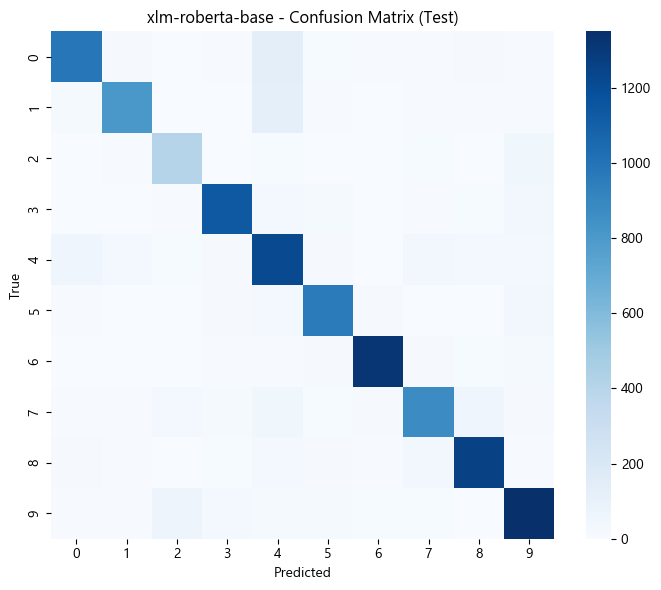

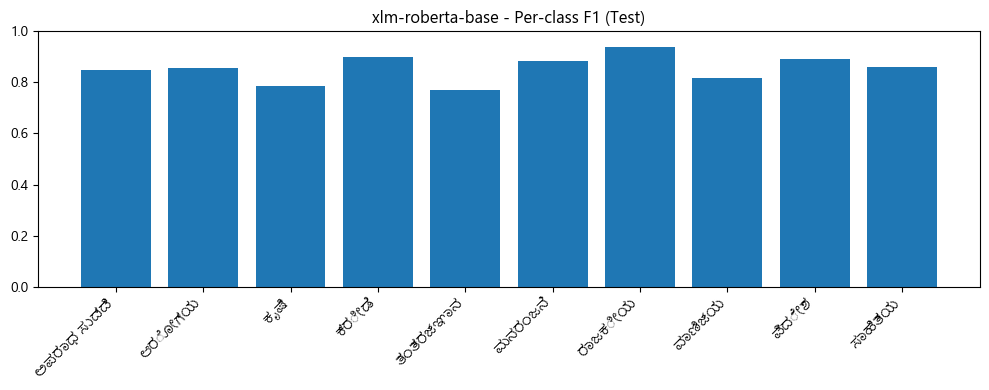

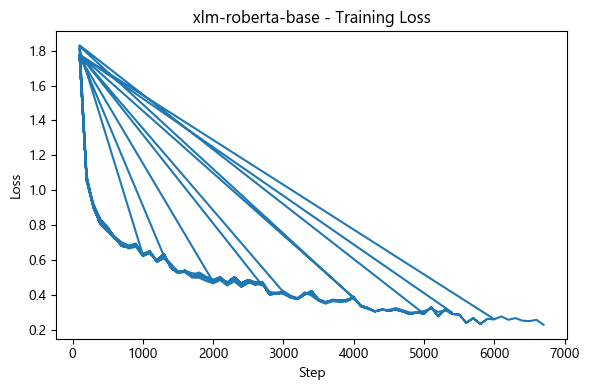


=== Summarizing bert-base-multilingual-cased (cls_kn_mbert) ===


Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

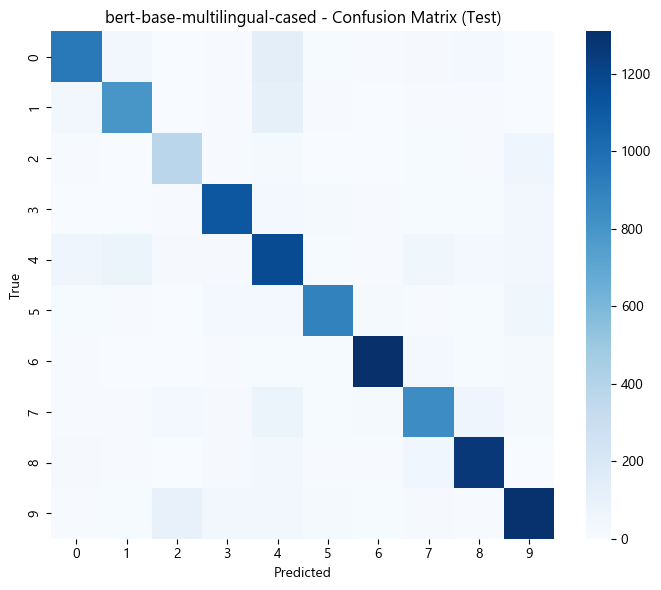

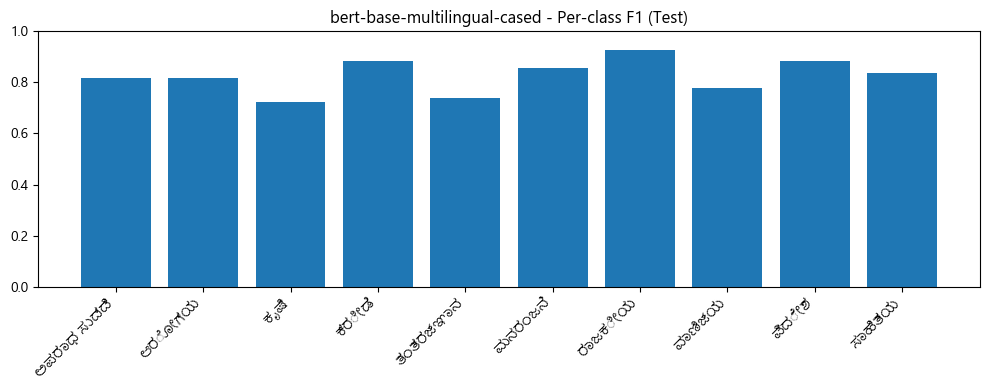

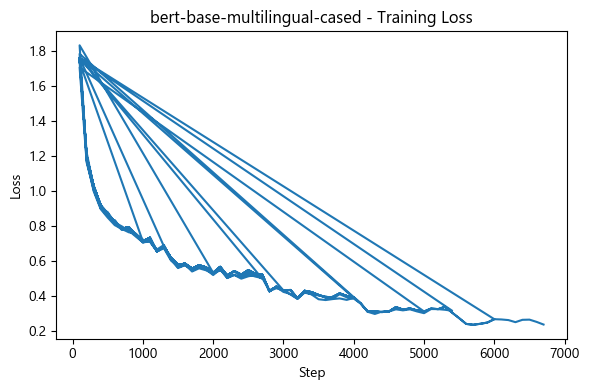


=== Summarizing distilbert-base-multilingual-cased (cls_kn_distilmbert) ===


Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

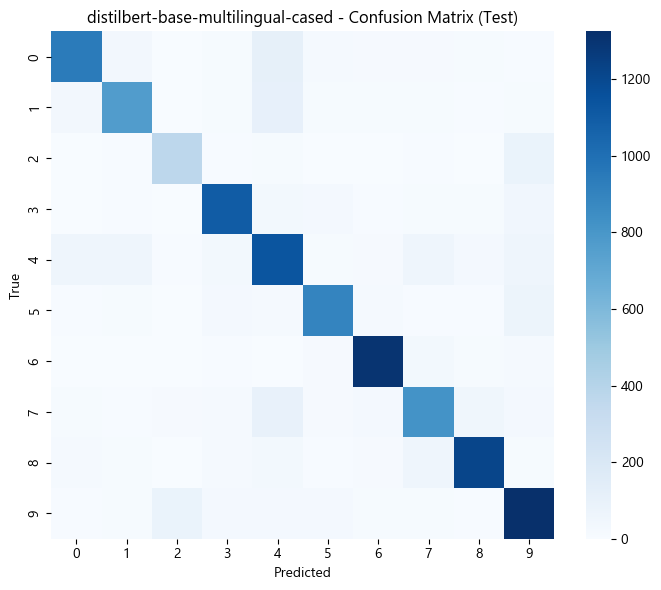

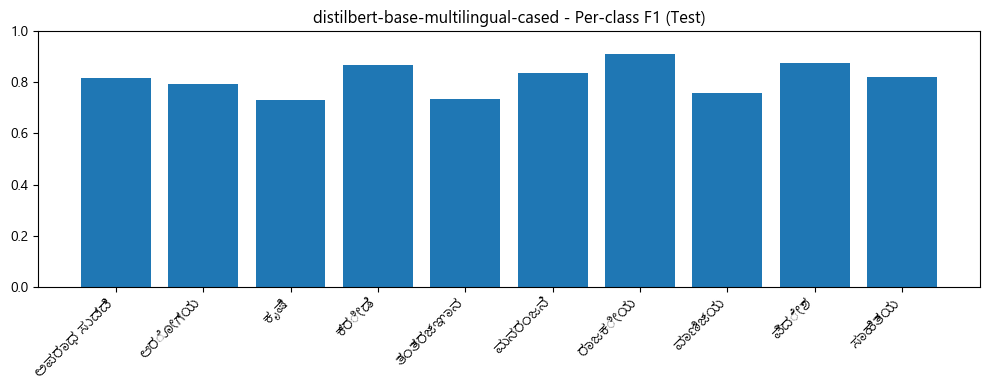

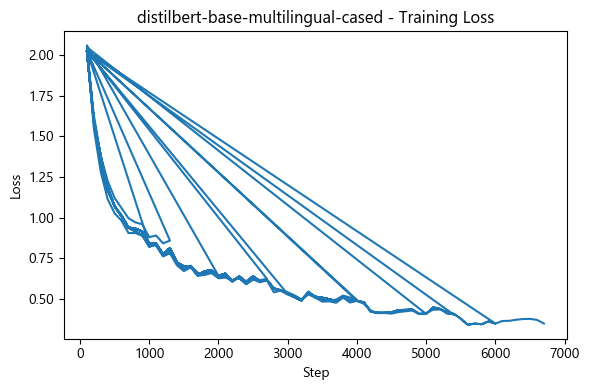


Summary Table:


,model,test_accuracy,test_macro_f1,test_macro_precision,test_macro_recall,num_train_log_points,num_eval_points
0,xlm-roberta-base,0.8589,0.8549,0.8581,0.8532,411,0
1,bert-base-multilingual-cased,0.8332,0.8265,0.8288,0.8255,411,0
2,distilbert-base-multilingual-cased,0.8219,0.8154,0.8187,0.8130,411,0


,model,test_accuracy,test_macro_f1,test_macro_precision,test_macro_recall,num_train_log_points,num_eval_points
0,xlm-roberta-base,0.8589,0.8549,0.8581,0.8532,411,0
1,bert-base-multilingual-cased,0.8332,0.8265,0.8288,0.8255,411,0
2,distilbert-base-multilingual-cased,0.8219,0.8154,0.8187,0.8130,411,0


In [31]:
# Aggregate fine-tune history and produce plots: train & eval loss, accuracy, macro F1, confusion matrix, per-class F1, reports
import os, json, glob, math, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, torch
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset

REQ_VARS = ['X_te','y_te_enc','le']
missing = [v for v in REQ_VARS if v not in globals()]
if missing:
    raise RuntimeError(f"Missing variables needed: {missing}. Re-run earlier cells.")

label_names = list(le.classes_)
model_dirs = [
    ('xlm-roberta-base','cls_kn_xlmr'),
    ('bert-base-multilingual-cased','cls_kn_mbert'),
    ('distilbert-base-multilingual-cased','cls_kn_distilmbert'),
]

os.makedirs('plots_summary', exist_ok=True)
summary_rows = []

# Helper to build dataset
def build_dataset(texts, labels, tokenizer, max_len=128):
    from datasets import Dataset
    ds = Dataset.from_dict({'text': list(texts), 'label': list(labels)})
    def tok(batch):
        return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=max_len)
    ds = ds.map(tok, batched=True)
    ds.set_format(type='torch', columns=['input_ids','attention_mask','label'])
    return ds

for ckpt, mdir in model_dirs:
    print(f"\n=== Summarizing {ckpt} ({mdir}) ===")
    best_dir = os.path.join(mdir, 'best_model')
    if not os.path.isdir(best_dir):
        print('Skipping (no best_model).')
        continue

    # Try to collect log history from any trainer_state.json under checkpoints
    log_entries = []
    for ts_path in sorted(glob.glob(os.path.join(mdir, 'checkpoint-*', 'trainer_state.json'))):
        try:
            with open(ts_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            log_entries.extend(data.get('log_history', []))
        except Exception as e:
            print('Could not read', ts_path, e)

    # Build DataFrames
    train_logs = [e for e in log_entries if 'loss' in e and 'learning_rate' in e]
    eval_logs = [e for e in log_entries if any(k.startswith('eval_') for k in e.keys())]
    df_train = pd.DataFrame(train_logs)
    df_eval = pd.DataFrame(eval_logs)

    # Load model + tokenizer and evaluate test set
    tokenizer = AutoTokenizer.from_pretrained(best_dir)
    model = AutoModelForSequenceClassification.from_pretrained(best_dir)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device).eval()
    test_ds = build_dataset(X_te.tolist(), y_te_enc, tokenizer)

    import torch.utils.data as tud
    loader = tud.DataLoader(test_ds, batch_size=64)
    logits_list = []
    with torch.no_grad():
        for batch in loader:
            inp = batch['input_ids'].to(device)
            att = batch['attention_mask'].to(device)
            logits = model(input_ids=inp, attention_mask=att).logits
            logits_list.append(logits.cpu().numpy())
    logits = np.concatenate(logits_list, axis=0)
    y_pred = np.argmax(logits, axis=-1)
    acc = (y_pred == y_te_enc).mean()
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_te_enc, y_pred, average='macro', zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(y_te_enc, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.title(f'{ckpt} - Confusion Matrix (Test)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    cm_path = os.path.join(mdir, 'confusion_matrix_summary.png')
    plt.savefig(cm_path, dpi=140)
    plt.show()

    # Per-class F1
    p_c, r_c, f1_c, support_c = precision_recall_fscore_support(y_te_enc, y_pred, average=None, zero_division=0)
    plt.figure(figsize=(10,4))
    plt.bar(range(len(label_names)), f1_c)
    plt.xticks(range(len(label_names)), label_names, rotation=45, ha='right')
    plt.ylim(0,1)
    plt.title(f'{ckpt} - Per-class F1 (Test)')
    plt.tight_layout()
    f1_path = os.path.join(mdir, 'per_class_f1_summary.png')
    plt.savefig(f1_path, dpi=140)
    plt.show()

    # Training Loss Curve
    if not df_train.empty:
        plt.figure(figsize=(6,4))
        plt.plot(df_train['step'], df_train['loss'], label='Train Loss')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title(f'{ckpt} - Training Loss')
        plt.tight_layout()
        loss_path = os.path.join(mdir, 'train_loss_curve.png')
        plt.savefig(loss_path, dpi=140)
        plt.show()

    # Eval curves (accuracy & macro F1 if present)
    if not df_eval.empty:
        # Try to parse eval_accuracy, eval_macro_f1 etc.
        metric_cols = [c for c in df_eval.columns if c.startswith('eval_')]
        if 'epoch' in df_eval.columns:
            x = df_eval['epoch']
        elif 'step' in df_eval.columns:
            x = df_eval['step']
        else:
            x = list(range(1, len(df_eval)+1))
        plt.figure(figsize=(6,4))
        if 'eval_accuracy' in df_eval.columns:
            plt.plot(x, df_eval['eval_accuracy'], marker='o', label='Val Acc')
        if 'eval_macro_f1' in df_eval.columns:
            plt.plot(x, df_eval['eval_macro_f1'], marker='s', label='Val Macro F1')
        if 'eval_loss' in df_eval.columns:
            plt.plot(x, df_eval['eval_loss'], marker='^', label='Val Loss')
        plt.ylim(0,1 if (df_eval.filter(like='eval_accuracy').size or df_eval.filter(like='eval_macro_f1').size) else None)
        plt.xlabel('Epoch' if 'epoch' in df_eval.columns else 'Step')
        plt.title(f'{ckpt} - Validation Curves')
        plt.legend()
        plt.tight_layout()
        eval_curve_path = os.path.join(mdir, 'val_curves.png')
        plt.savefig(eval_curve_path, dpi=140)
        plt.show()

    # Classification report
    report = classification_report(y_te_enc, y_pred, target_names=label_names, digits=4)
    with open(os.path.join(mdir, 'classification_report_summary.txt'), 'w', encoding='utf-8') as f:
        f.write(report)

    summary_rows.append({
        'model': ckpt,
        'test_accuracy': round(float(acc),4),
        'test_macro_f1': round(float(f1_macro),4),
        'test_macro_precision': round(float(p_macro),4),
        'test_macro_recall': round(float(r_macro),4),
        'num_train_log_points': len(df_train),
        'num_eval_points': len(df_eval)
    })

summary_df = pd.DataFrame(summary_rows)
print('\nSummary Table:')
display(summary_df)
summary_df.to_csv('plots_summary/model_test_summary.csv', index=False)
summary_df

In [33]:
finetune_results.keys()

dict_keys(['xlm-roberta-base_run_1', 'xlm-roberta-base_run_2', 'xlm-roberta-base_run_3', 'xlm-roberta-base_run_4', 'xlm-roberta-base_run_5', 'bert-base-multilingual-cased_run_1', 'bert-base-multilingual-cased_run_2', 'bert-base-multilingual-cased_run_3', 'bert-base-multilingual-cased_run_4', 'bert-base-multilingual-cased_run_5', 'distilbert-base-multilingual-cased_run_1', 'distilbert-base-multilingual-cased_run_2', 'distilbert-base-multilingual-cased_run_3', 'distilbert-base-multilingual-cased_run_4', 'distilbert-base-multilingual-cased_run_5'])

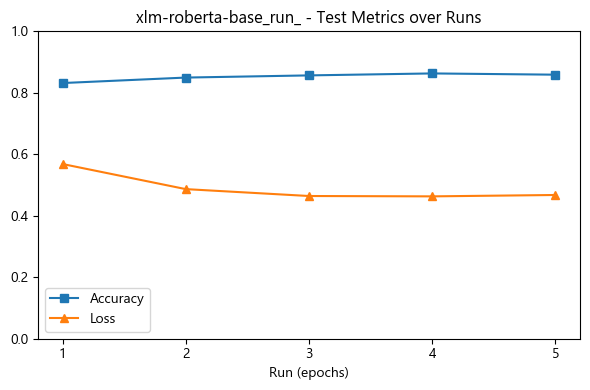

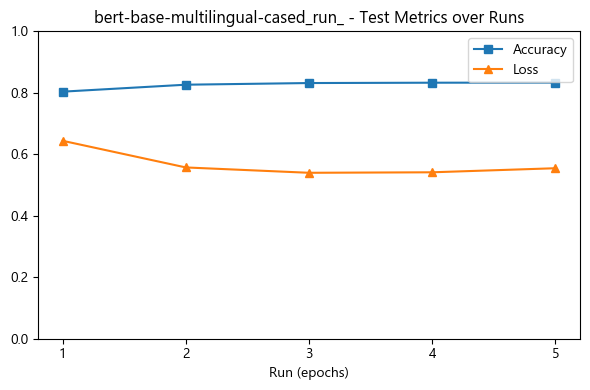

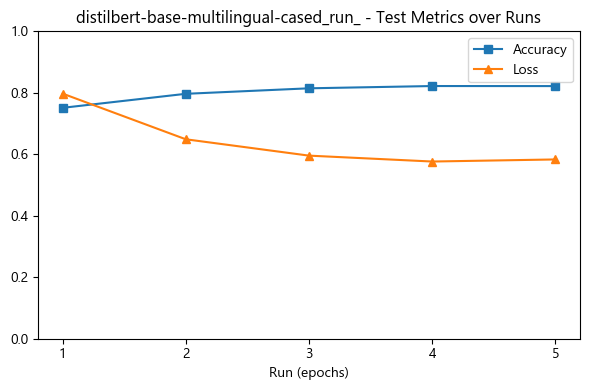

In [37]:
plot_models = ['xlm-roberta-base_run_', 'bert-base-multilingual-cased_run_', 'distilbert-base-multilingual-cased_run_']

for pm in plot_models:
    accs = []
    loss = []
    x_labels = list(range(1,6))
    for run in range(1,6):
        key = f'{pm}{run}'
        if key in finetune_results and 'eval_macro_f1' in finetune_results[key]:
            accs.append(finetune_results[key]['eval_accuracy'])
            loss.append(finetune_results[key]['eval_loss'])
    plt.figure(figsize=(6,4))
    plt.plot(x_labels, accs, marker='s', label='Accuracy')
    plt.plot(x_labels, loss, marker='^', label='Loss')
    plt.xticks(x_labels)
    plt.ylim(0,1)
    plt.xlabel('Run (epochs)')
    plt.title(f'{pm} - Test Metrics over Runs')
    plt.legend()
    plt.tight_layout()
    plot_path = os.path.join('plots_summary', f'{pm.strip("_")}_test_metrics_over_runs.png')
    plt.savefig(plot_path, dpi=140)
    plt.show()


=== Summarizing xlm-roberta-base (cls_kn_xlmr) ===


Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

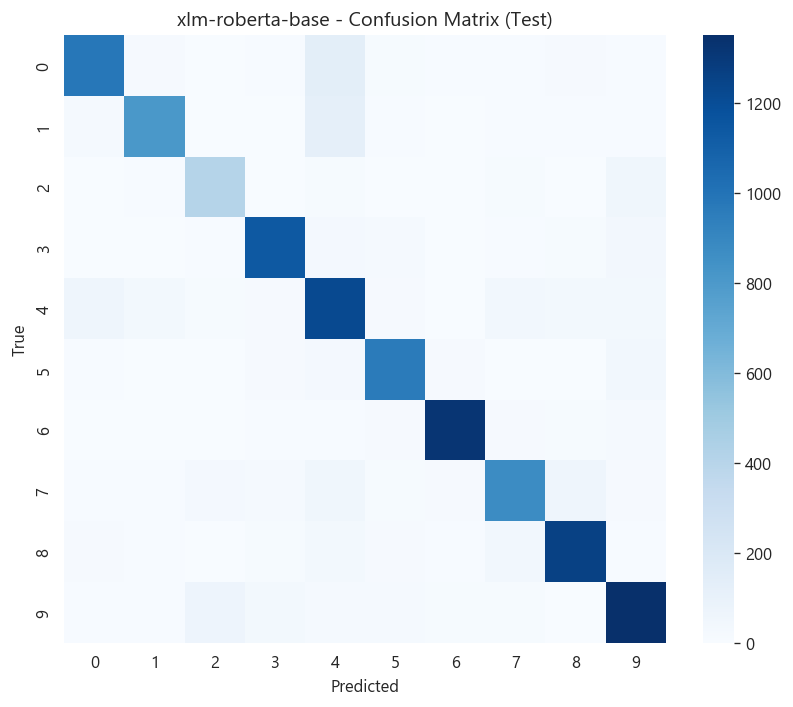

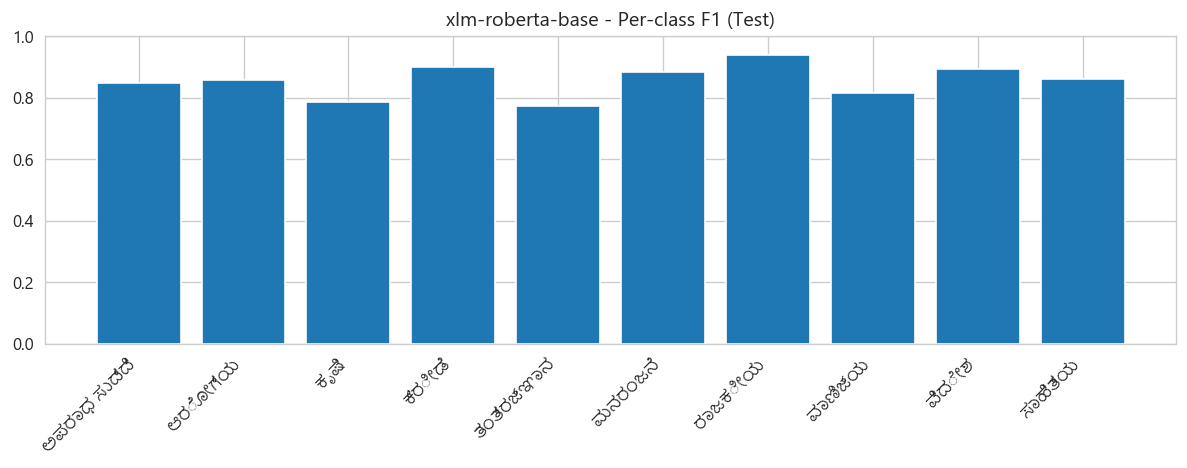

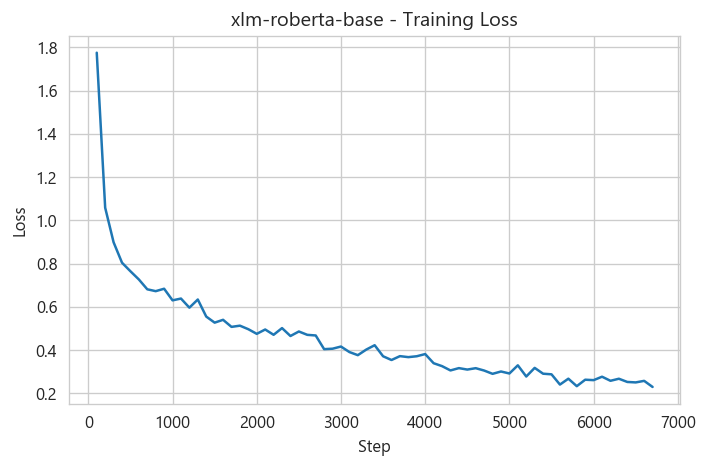


=== Summarizing bert-base-multilingual-cased (cls_kn_mbert) ===


Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

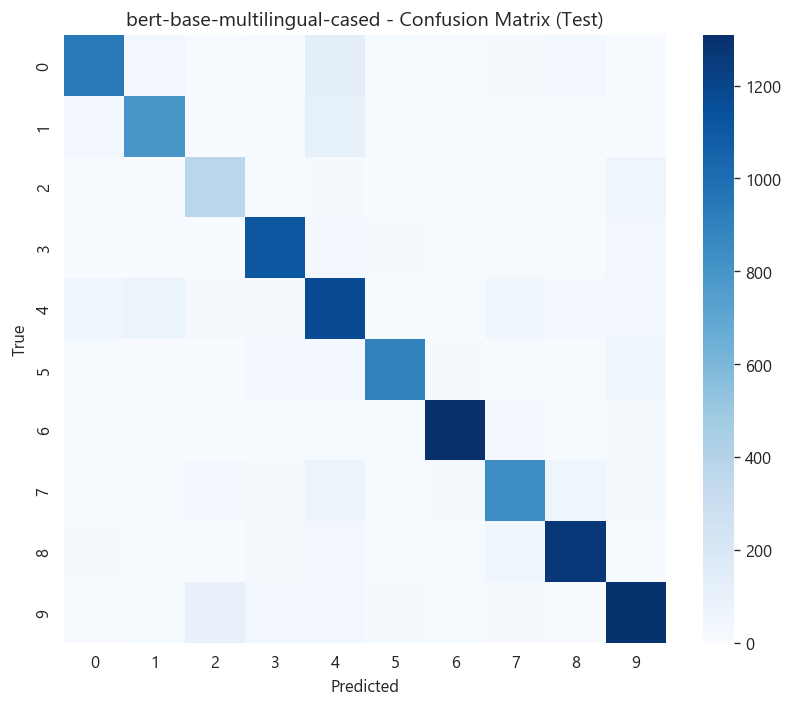

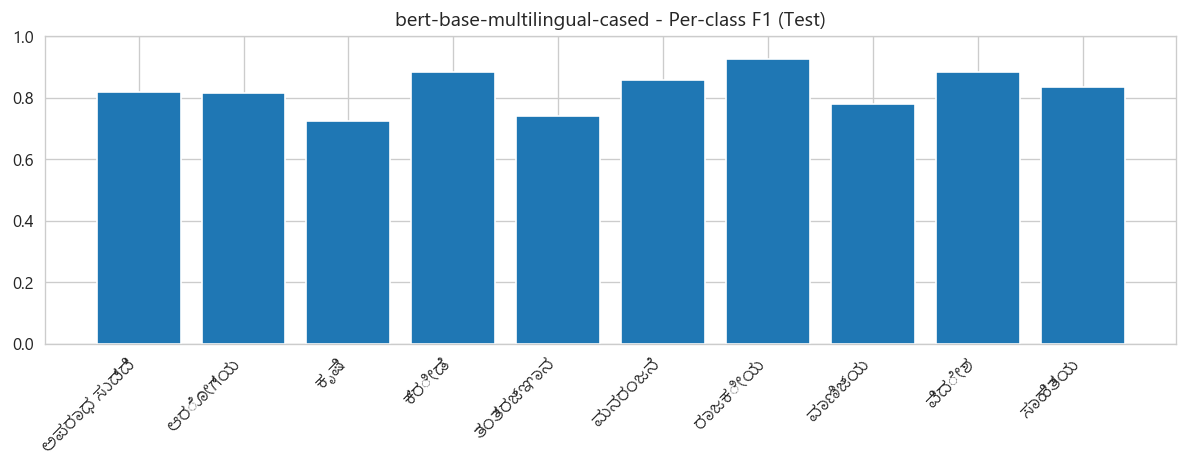

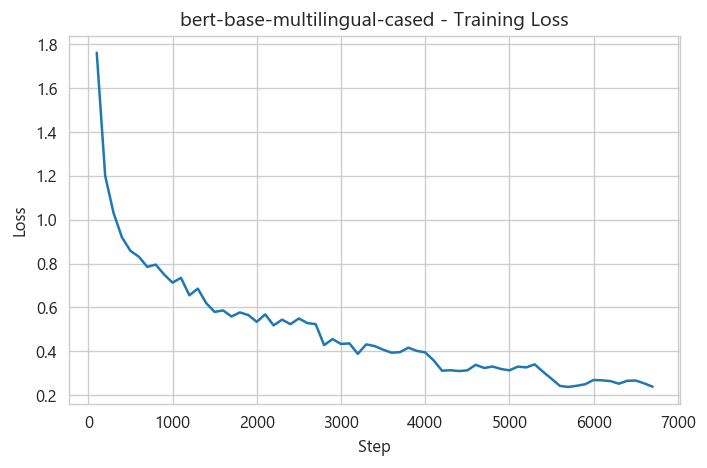


=== Summarizing distilbert-base-multilingual-cased (cls_kn_distilmbert) ===


Map:   0%|          | 0/12020 [00:00<?, ? examples/s]

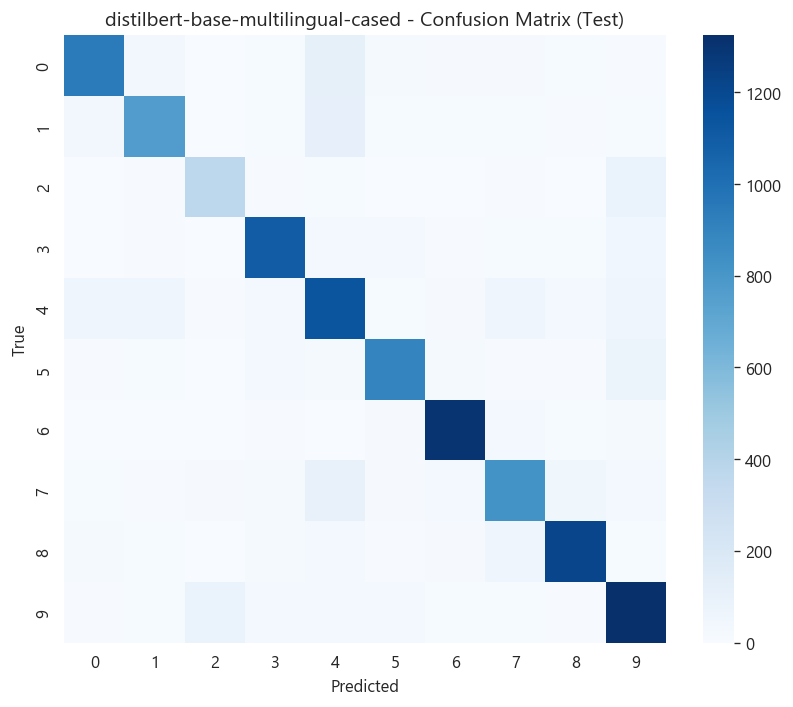

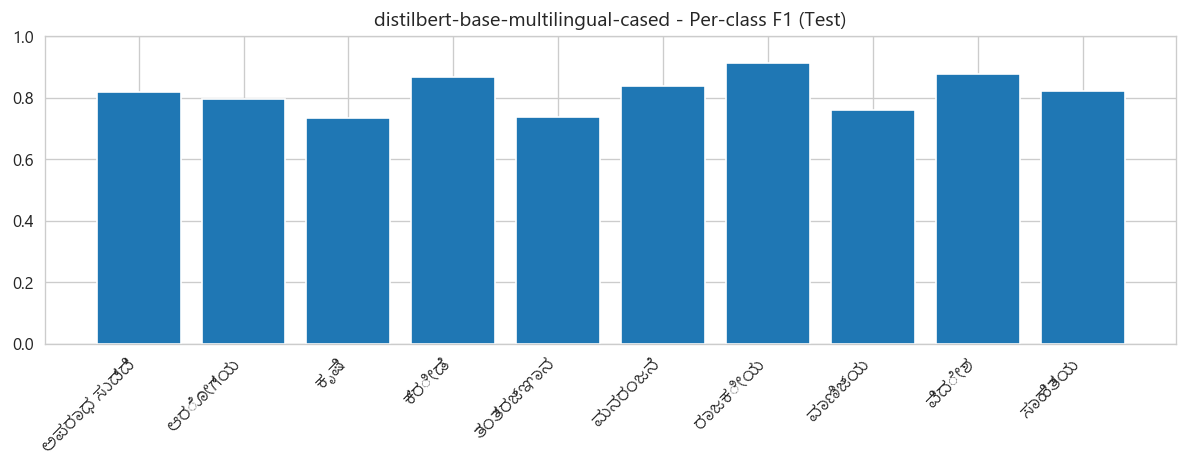

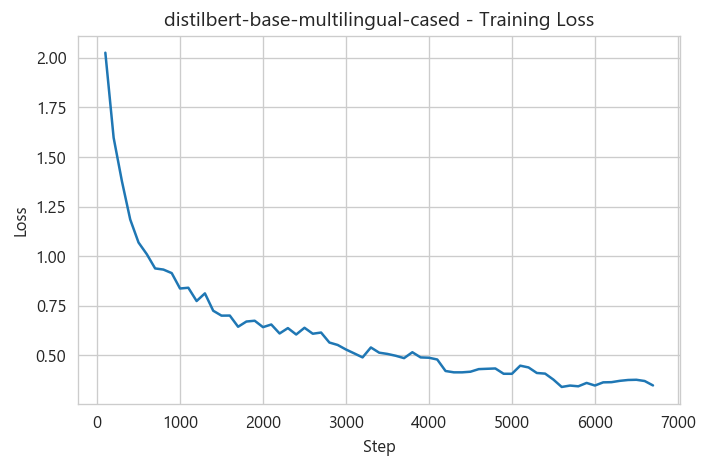


Summary Table:


,model,test_accuracy,test_macro_f1,test_macro_precision,test_macro_recall,num_train_log_points,num_eval_points
0,xlm-roberta-base,0.8589,0.8549,0.8581,0.8532,411,0
1,bert-base-multilingual-cased,0.8332,0.8265,0.8288,0.8255,411,0
2,distilbert-base-multilingual-cased,0.8219,0.8154,0.8187,0.8130,411,0


In [54]:
# Aggregate fine-tune history and produce plots: train & eval loss, accuracy, macro F1, confusion matrix, per-class F1, reports
import os, json, glob, math, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, torch
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset

REQ_VARS = ['X_te','y_te_enc','le']
missing = [v for v in REQ_VARS if v not in globals()]
if missing:
    raise RuntimeError(f"Missing variables needed: {missing}. Re-run earlier cells.")

label_names = list(le.classes_)
model_dirs = [
    ('xlm-roberta-base','cls_kn_xlmr'),
    ('bert-base-multilingual-cased','cls_kn_mbert'),
    ('distilbert-base-multilingual-cased','cls_kn_distilmbert'),
]

os.makedirs('plots_summary', exist_ok=True)
summary_rows = []

# Helper to build dataset
def build_dataset(texts, labels, tokenizer, max_len=128):
    from datasets import Dataset
    ds = Dataset.from_dict({'text': list(texts), 'label': list(labels)})
    def tok(batch):
        return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=max_len)
    ds = ds.map(tok, batched=True)
    ds.set_format(type='torch', columns=['input_ids','attention_mask','label'])
    return ds

for ckpt, mdir in model_dirs:
    print(f"\n=== Summarizing {ckpt} ({mdir}) ===")
    best_dir = os.path.join(mdir, 'best_model')
    if not os.path.isdir(best_dir):
        print('Skipping (no best_model).')
        continue

    # Try to collect log history from any trainer_state.json under checkpoints
    log_entries = []
    for ts_path in sorted(glob.glob(os.path.join(mdir, 'checkpoint-*', 'trainer_state.json'))):
        try:
            with open(ts_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            log_entries.extend(data.get('log_history', []))
        except Exception as e:
            print('Could not read', ts_path, e)

    # Build DataFrames
    train_logs = [e for e in log_entries if 'loss' in e and 'learning_rate' in e]
    eval_logs = [e for e in log_entries if any(k.startswith('eval_') for k in e.keys())]
    df_train = pd.DataFrame(train_logs)
    df_eval = pd.DataFrame(eval_logs)

    # Load model + tokenizer and evaluate test set
    tokenizer = AutoTokenizer.from_pretrained(best_dir)
    model = AutoModelForSequenceClassification.from_pretrained(best_dir)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device).eval()
    test_ds = build_dataset(X_te.tolist(), y_te_enc, tokenizer)

    import torch.utils.data as tud
    loader = tud.DataLoader(test_ds, batch_size=64)
    logits_list = []
    with torch.no_grad():
        for batch in loader:
            inp = batch['input_ids'].to(device)
            att = batch['attention_mask'].to(device)
            logits = model(input_ids=inp, attention_mask=att).logits
            logits_list.append(logits.cpu().numpy())
    logits = np.concatenate(logits_list, axis=0)
    y_pred = np.argmax(logits, axis=-1)
    acc = (y_pred == y_te_enc).mean()
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_te_enc, y_pred, average='macro', zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(y_te_enc, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.title(f'{ckpt} - Confusion Matrix (Test)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    cm_path = os.path.join(mdir, 'confusion_matrix_summary.png')
    plt.savefig(cm_path, dpi=140)
    plt.show()

    # Per-class F1
    p_c, r_c, f1_c, support_c = precision_recall_fscore_support(y_te_enc, y_pred, average=None, zero_division=0)
    plt.rcParams['font.family'] = ['Nirmala UI', 'sans-serif']
    plt.figure(figsize=(10,4))
    plt.bar(range(len(label_names)), f1_c)
    plt.xticks(range(len(label_names)), label_names, rotation=45, ha='right')
    plt.ylim(0,1)
    plt.title(f'{ckpt} - Per-class F1 (Test)')
    plt.tight_layout()
    f1_path = os.path.join(mdir, 'per_class_f1_summary.png')
    plt.savefig(f1_path, dpi=140)
    plt.show()

    # Training Loss Curve
    if not df_train.empty:
        plt.figure(figsize=(6,4))
        plt.plot(df_train['step'][344:], df_train['loss'][344:], label='Train Loss')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title(f'{ckpt} - Training Loss')
        plt.tight_layout()
        loss_path = os.path.join(mdir, 'train_loss_curve.png')
        plt.savefig(loss_path, dpi=140)
        plt.show()

    # Eval curves (accuracy & macro F1 if present)
    if not df_eval.empty:
        # Try to parse eval_accuracy, eval_macro_f1 etc.
        metric_cols = [c for c in df_eval.columns if c.startswith('eval_')]
        if 'epoch' in df_eval.columns:
            x = df_eval['epoch']
        elif 'step' in df_eval.columns:
            x = df_eval['step']
        else:
            x = list(range(1, len(df_eval)+1))
        plt.figure(figsize=(6,4))
        if 'eval_accuracy' in df_eval.columns:
            plt.plot(x, df_eval['eval_accuracy'], marker='o', label='Val Acc')
        if 'eval_macro_f1' in df_eval.columns:
            plt.plot(x, df_eval['eval_macro_f1'], marker='s', label='Val Macro F1')
        if 'eval_loss' in df_eval.columns:
            plt.plot(x, df_eval['eval_loss'], marker='^', label='Val Loss')
        plt.ylim(0,1 if (df_eval.filter(like='eval_accuracy').size or df_eval.filter(like='eval_macro_f1').size) else None)
        plt.xlabel('Epoch' if 'epoch' in df_eval.columns else 'Step')
        plt.title(f'{ckpt} - Validation Curves')
        plt.legend()
        plt.tight_layout()
        eval_curve_path = os.path.join(mdir, 'val_curves.png')
        plt.savefig(eval_curve_path, dpi=140)
        plt.show()

    # Classification report
    report = classification_report(y_te_enc, y_pred, target_names=label_names, digits=4)
    with open(os.path.join(mdir, 'classification_report_summary.txt'), 'w', encoding='utf-8') as f:
        f.write(report)

    summary_rows.append({
        'model': ckpt,
        'test_accuracy': round(float(acc),4),
        'test_macro_f1': round(float(f1_macro),4),
        'test_macro_precision': round(float(p_macro),4),
        'test_macro_recall': round(float(r_macro),4),
        'num_train_log_points': len(df_train),
        'num_eval_points': len(df_eval)
    })

summary_df = pd.DataFrame(summary_rows)
print('\nSummary Table:')
display(summary_df)
summary_df.to_csv('plots_summary/model_test_summary.csv', index=False)

In [48]:
df_train[df_train['step']==100]

,epoch,grad_norm,learning_rate,loss,step
0,0.07391,6.910320,0.000020,2.0258,100
10,0.07391,6.836153,0.000019,2.0270,100
23,0.07391,6.910320,0.000020,2.0258,100
43,0.07391,6.467636,0.000019,2.0601,100
70,0.07391,6.910320,0.000020,2.0258,100
100,0.07391,6.910320,0.000020,2.0258,100
140,0.07391,5.192056,0.000020,2.0265,100
180,0.07391,6.910320,0.000020,2.0258,100
230,0.07391,7.246581,0.000020,2.0489,100
284,0.07391,6.910320,0.000020,2.0258,100


In [58]:
finetune_results['bert-base-multilingual-cased_run_1'].keys()

dict_keys(['eval_loss', 'eval_accuracy', 'eval_macro_f1', 'eval_macro_precision', 'eval_macro_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])

In [62]:
model_names = ['xlm-roberta-base_run_', 'bert-base-multilingual-cased_run_', 'distilbert-base-multilingual-cased_run_']

for mn in model_names:
    for e in [1,5]:
        key = f'{mn}{e}'
        print(f"{key}: Acc={finetune_results[key]['eval_accuracy']:.4f}, MacroF1={finetune_results[key]['eval_macro_f1']:.4f}, Precision={finetune_results[key]['eval_macro_precision']:.4f}, Recall={finetune_results[key]['eval_macro_recall']:.4f}")

xlm-roberta-base_run_1: Acc=0.8318, MacroF1=0.8253, Precision=0.8282, Recall=0.8256
xlm-roberta-base_run_5: Acc=0.8590, MacroF1=0.8550, Precision=0.8582, Recall=0.8533
bert-base-multilingual-cased_run_1: Acc=0.8037, MacroF1=0.7951, Precision=0.7989, Recall=0.7927
bert-base-multilingual-cased_run_5: Acc=0.8332, MacroF1=0.8265, Precision=0.8288, Recall=0.8255
distilbert-base-multilingual-cased_run_1: Acc=0.7512, MacroF1=0.7390, Precision=0.7399, Recall=0.7397
distilbert-base-multilingual-cased_run_5: Acc=0.8219, MacroF1=0.8154, Precision=0.8186, Recall=0.8130
